In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, make_scorer, precision_recall_curve, roc_curve, auc


# Frame the Problem and Look at the Big Picture

### Define the Objective in Business Terms
The objective is to develop a predictive model to identify fraudulent credit card transactions from a given dataset. This model aims to support financial institutions or payment processors in detecting and preventing fraud in real time, reducing financial losses and protecting customer accounts. The model should focus on prioritizing possible fraudulent transactions but still make sure that it is able to identify true fraudulent transactions as not to inconvenience customers.

### How Will Your Solution Be Used?
The solution will be implemented as part of the transaction processing system, providing real-time fraud classification. When a transaction is flagged as fraudulent, it will either be declined or sent for manual review by a fraud analyst. The client will use the model to improve their fraud detection efficiency, reduce reliance on manual reviews, and maintain customer trust by proactively addressing security concerns.

### What Are the Current Solutions/Workarounds (If Any)?
Currently, most fraud detection systems use rule-based engines that rely on predefined thresholds (e.g., large transactions or unusual locations). While effective to a degree, these systems often struggle with adapting to evolving fraud patterns and result in high false-positive rates. Manual reviews are used to address flagged transactions, which can be labor-intensive, slow, and costly.

### How Should You Frame This Problem?
This is a supervised binary classification problem where the goal is to classify each transaction as either "fraudulent" or "non-fraudulent" based on labeled historical data. The model will likely be deployed in an batch learning setting, because we could update the model in a certain timeframe as opposed to online learning where it is possible to use as well, but would need to be closely inspected as it could potentially inconvience customers where precision and/or recall could decrease. 

## How Should Performance Be Measured?
- **Metrics:**
  - Precision: To ensure flagged transactions are truly fraudulent, minimizing inconvenience to customers.
  - Recall (Prioritize): To catch as many fraudulent transactions as possible.
  - F1 Score: To balance precision and recall.
  - ROC-AUC: To evaluate overall classifier performance.

### Is the Performance Measure Aligned with the Business Objective?
Yes, the performance measures align with the business objective of reducing fraud while maintaining a positive customer experience. Emphasis should be placed on recall to ensure fraud is detected, but precision is also critical to prevent disruption for legitimate customers.

### What Would Be the Minimum Performance Needed to Reach the Business Objective?
The model must outperform the current rule-based system in terms of fraud detection rate while maintaining or improving the false-positive rate. For example, achieving at least 90% recall with a precision above 80% might be a realistic goal to satisfy business requirements.

### What Are Comparable Problems? Can You Reuse Experience or Tools?
- Comparable problems include the **Squirrel Prediction Model** and **Early Spring Prediction Model**, as they both involved working with a binary classification problem.
- Tools such as the **DBScan algorithm** used in the Squirrel model might be useful to find clusters as well as other clustering algorithms used in previous works such the notebook **Clustering**.

### Is Human Expertise Available?
Human expertise is available in the form of fraud analysts who currently review flagged transactions. Their domain knowledge can guide feature selection and model validation. Analysts can also provide labeled data to improve model performance and adapt it to emerging fraud trends.

### How Would You Solve the Problem Manually?
Manual fraud detection involves analyzing transaction patterns for anomalies such as:
- Unusual transaction locations or times.
- Large transaction amounts.
- Multiple small transactions in a short time span.  
Analysts would cross-reference transaction data with customer profiles and historical behaviors to assess risk. While effective for small datasets, this approach is impractical for high transaction volumes due to its inefficiency and susceptibility to human error.

### List the Assumptions You Have Made So Far (Verify if Possible)
The dataset is assumed to accurately represent real-world fraud patterns, containing sufficiently labeled examples of both fraudulent and non-fraudulent transactions. It is expected that fraudulent transactions make up only a small proportion compared to non-fraudulent ones. The features in the dataset, such as transaction amount, location, and time, are presumed to be predictive of fraud, with fraudulent transactions exhibiting distinguishable patterns from legitimate ones. Given the imbalance in the dataset, stratification will be necessary to ensure proper representation of both classes during training. This assumption is supported by the observation that fraudulent transactions are only a small fraction of the total samples.

In [2]:
# function to concat fraudTest.csv and fraudTrain.csv datasets

def concat_data():
    # read the datasets
    fraudTest = pd.read_csv('fraudTest.csv')
    fraudTrain = pd.read_csv('fraudTrain.csv')
    # concat the datasets
    data = pd.concat([fraudTrain, fraudTest], axis=0)
    return data



In [3]:
data = concat_data()

In [5]:
#search for NAN values

data.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud               i

In [7]:
data.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,5.371934e+05,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03
std,3.669110e+05,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00
25%,2.315490e+05,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00
50%,4.630980e+05,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00
75%,8.335758e+05,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [8]:
data["is_fraud"].value_counts()

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

The original dataset gave us a train and test set obviously consisting of the same variables. We decided to recombine them and split them ourselves just to make sure the splitting was random.

No NA values in the data. This is a very clean dataset and makes the cleaning the data section way easier.

23 features. A decent amount. Just looking at the feature names I want to look deeper into what merchant, amt, Unnamed, trans_num, and unix_time are.

11 of our features are numbers, only a few of them should actually be treated like that though (ie. lat and long should not be scaled or anything).

Target label is is_fraud. There are obviously a lot more cases of not being fraud over fraud.  This is the only feature we will stratify on as it is a classification problem and the target label has to be stratified ALWAYS.


In [9]:
# stratify on is_fraud to have the same proportion of fraud in train and test set take 20% of the data for the test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["is_fraud"]), data["is_fraud"], test_size=0.2, stratify=data["is_fraud"], random_state=42)

In [10]:
# train set

train = X_train.copy()
train['is_fraud'] = y_train

array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'cc_num'}>,
        <Axes: title={'center': 'amt'}>],
       [<Axes: title={'center': 'zip'}>, <Axes: title={'center': 'lat'}>,
        <Axes: title={'center': 'long'}>],
       [<Axes: title={'center': 'city_pop'}>,
        <Axes: title={'center': 'unix_time'}>,
        <Axes: title={'center': 'merch_lat'}>],
       [<Axes: title={'center': 'merch_long'}>,
        <Axes: title={'center': 'is_fraud'}>, <Axes: >]], dtype=object)

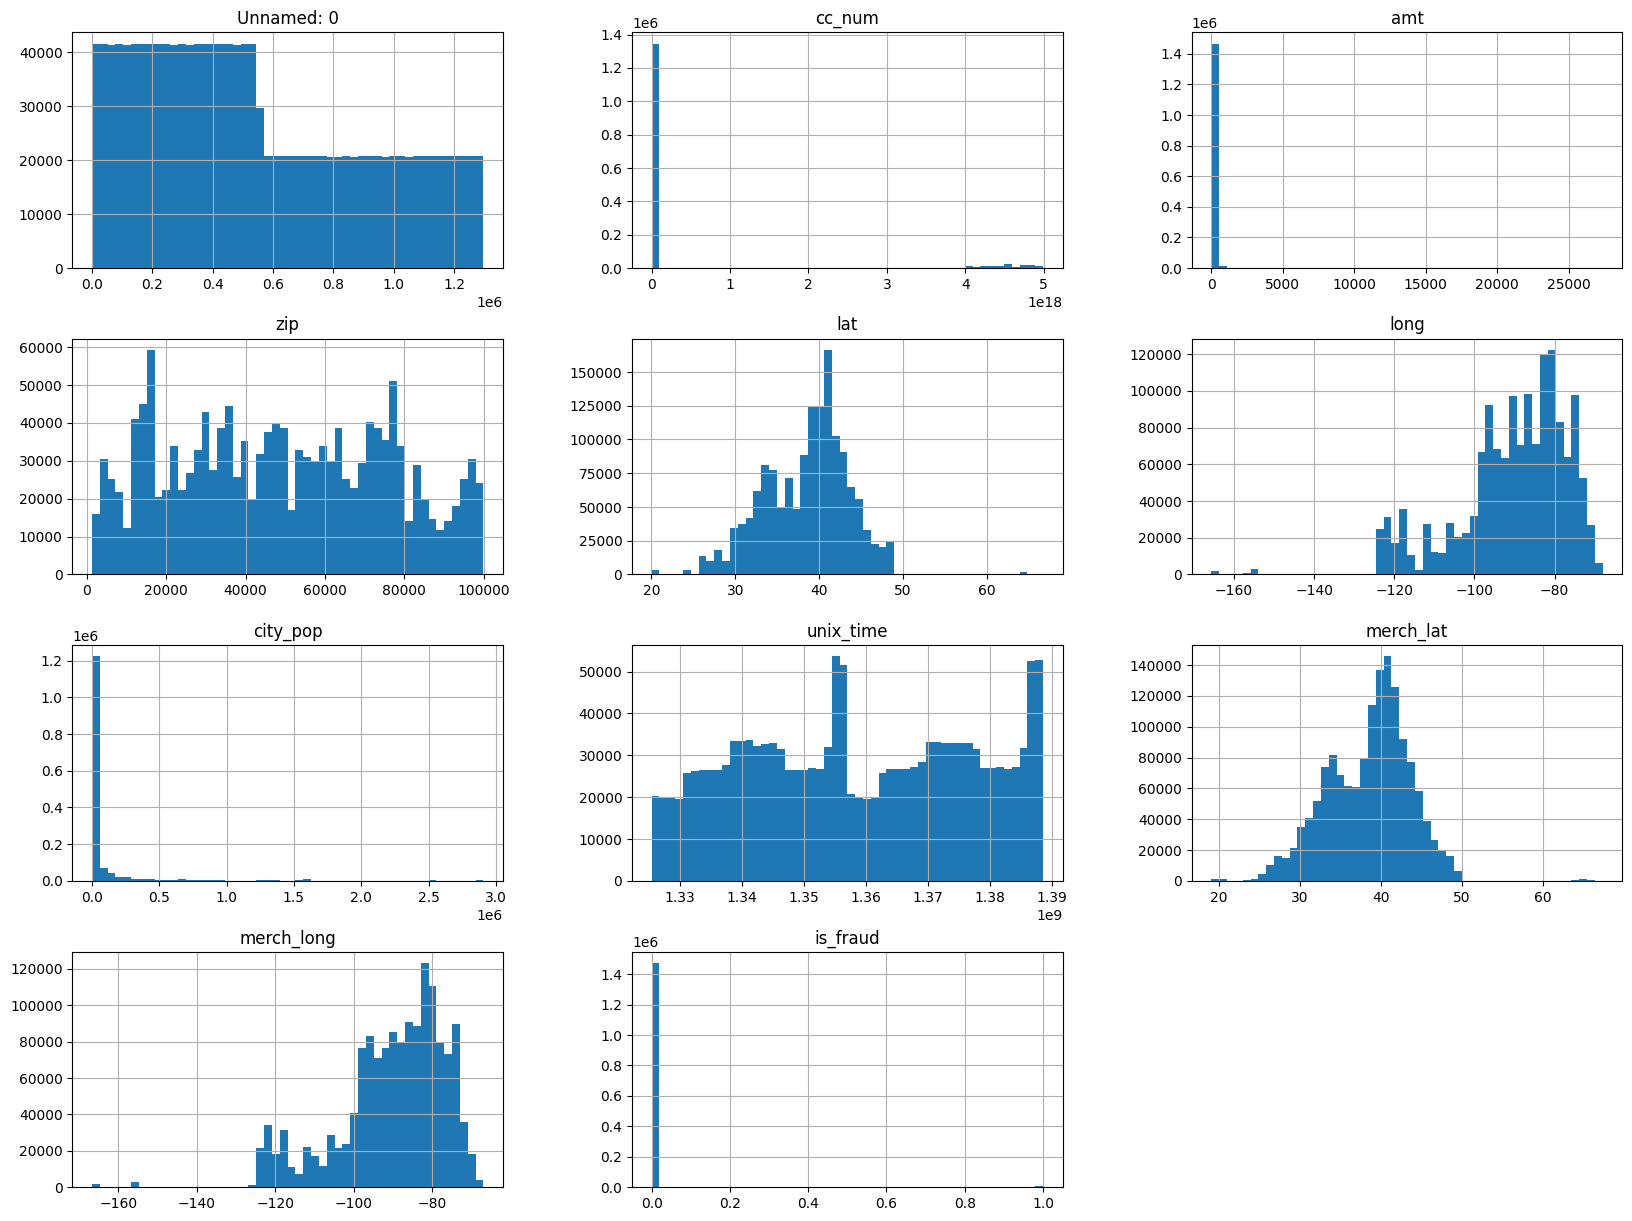

In [12]:
#histogram of train set

train.hist(bins=50, figsize=(20,15))